The objective of this notebook is to:
- join all of the kraken results with the sample metadata
- subset to samples with metadata
- collapse P3+ into Other
- do PCA, coloring by metadata
- do GLM modelling to determine if any have significance

In [125]:
import Pkg
pkgs = [
    "Revise",
    "DataFrames",
    "StatsBase",
    "StatsPlots",
    "uCSV",
    "ProgressMeter",
    "Distances",
    "Clustering",
    "Colors",
    "MultivariateStats",
    "Dates",
    "CategoricalArrays",
    "GLM",
    "Statistics",
    "UMAP"
]
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end
import Mycelia

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


LoadError: Unsatisfiable requirements detected for package [38;5;11mDistributions [31c24e10][39m:
 [38;5;11mDistributions [31c24e10][39m log:
 ├─possible versions are: [38;5;11m0.16.0-0.25.104[39m or uninstalled
 ├─restricted to versions [38;5;11m*[39m by [38;5;13mMycelia [453d265d][39m, leaving only versions: [38;5;11m0.16.0-0.25.104[39m
 │ └─[38;5;13mMycelia [453d265d][39m log:
 │   ├─possible versions are: [38;5;13m0.1.0[39m or uninstalled
 │   └─[38;5;13mMycelia [453d265d][39m is fixed to version [38;5;13m0.1.0[39m
 ├─restricted by compatibility requirements with [38;5;12mStatsBase [2913bbd2][39m to versions: [38;5;11m0.25.88-0.25.104[39m or uninstalled, leaving only versions: [38;5;11m0.25.88-0.25.104[39m
 │ └─[38;5;12mStatsBase [2913bbd2][39m log:
 │   ├─possible versions are: [38;5;12m0.24.0-0.34.2[39m or uninstalled
 │   ├─restricted to versions [38;5;12m*[39m by [38;5;13mMycelia [453d265d][39m, leaving only versions: [38;5;12m0.24.0-0.34.2[39m
 │   │ └─[38;5;13mMycelia [453d265d][39m log: see above
 │   └─restricted to versions [38;5;12m0.34.2[39m by an explicit requirement, leaving only versions: [38;5;12m0.34.2[39m
 └─restricted by compatibility requirements with [38;5;2mLsqFit [2fda8390][39m to versions: [38;5;11m0.16.0-0.21.12[39m — no versions left
   └─[38;5;2mLsqFit [2fda8390][39m log:
     ├─possible versions are: [38;5;2m0.5.0-0.15.0[39m or uninstalled
     ├─restricted to versions [38;5;2m*[39m by [38;5;13mMycelia [453d265d][39m, leaving only versions: [38;5;2m0.5.0-0.15.0[39m
     │ └─[38;5;13mMycelia [453d265d][39m log: see above
     ├─restricted by compatibility requirements with [38;5;12mStatsBase [2913bbd2][39m to versions: [38;5;2m[0.5.0-0.6.0, 0.14.0-0.15.0][39m or uninstalled, leaving only versions: [38;5;2m[0.5.0-0.6.0, 0.14.0-0.15.0][39m
     │ └─[38;5;12mStatsBase [2913bbd2][39m log: see above
     └─restricted by compatibility requirements with [38;5;3mUMAP [c4f8c510][39m to versions: [38;5;2m0.6.0-0.13.0[39m, leaving only versions: [38;5;2m0.6.0[39m
       └─[38;5;3mUMAP [c4f8c510][39m log:
         ├─possible versions are: [38;5;3m0.1.0-0.1.10[39m or uninstalled
         ├─restricted to versions [38;5;3m*[39m by an explicit requirement, leaving only versions: [38;5;3m0.1.0-0.1.10[39m
         └─restricted by compatibility requirements with [38;5;5mDistances [b4f34e82][39m to versions: [38;5;3m0.1.8-0.1.10[39m or uninstalled, leaving only versions: [38;5;3m0.1.8-0.1.10[39m
           └─[38;5;5mDistances [b4f34e82][39m log:
             ├─possible versions are: [38;5;5m0.7.0-0.10.11[39m or uninstalled
             ├─restricted to versions [38;5;5m*[39m by [38;5;13mMycelia [453d265d][39m, leaving only versions: [38;5;5m0.7.0-0.10.11[39m
             │ └─[38;5;13mMycelia [453d265d][39m log: see above
             └─restricted to versions [38;5;5m0.10.11[39m by an explicit requirement, leaving only versions: [38;5;5m0.10.11[39m

In [2]:
data_dir = joinpath(dirname(pwd()), "data")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data"

In [3]:
results_dir = joinpath(data_dir, "results")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results"

In [ ]:
# load in metadata
metadata_dir = joinpath(dirname(pwd()), "metadata")

exposome_environmental_data = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "metadata_exposome.rds.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

joint_sample_metadata = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "exposome/joint_sample_metadata.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

@assert joint_sample_metadata[!, "Library Name"] == joint_sample_metadata[!, "LibraryName"]
joint_metadata = DataFrames.innerjoin(
    joint_sample_metadata,
    exposome_environmental_data,
    on="Library Name" => "samplenames");


# # recode P3 and beyond to Other, since they don't have enough samples to do much analysis on
# joint_metadata[!, "aownership"] = map(x -> x in Set(["P1", "P2"]) ? x : "Others", joint_metadata[!, "aownership"])

joint_metadata[!, "date.start"] = Dates.Date.(joint_metadata[!, "date.start"], "yyyy-mm-dd")
joint_metadata[!, "date.end"] = Dates.Date.(joint_metadata[!, "date.end"], "yyyy-mm-dd")
# use this if we want to unified axis across all participants, which I don't think we do
# joint_metadata[!, "date.start_relative"] = joint_metadata[!, "date.start"] .- first(joint_metadata[!, "date.start"])
# joint_metadata[!, "date.end_relative"] = joint_metadata[!, "date.end"] .- first(joint_metadata[!, "date.start"])
joint_metadata[!, "duration"] = joint_metadata[!, "date.end"] .- joint_metadata[!, "date.start"]

joint_metadata[!, "temperature"] = something.(tryparse.(Float64, joint_metadata[!, "temperature"]), missing)
joint_metadata[!, "humid"] = something.(tryparse.(Float64, joint_metadata[!, "humid"]), missing)
joint_metadata[!, "particle"] = something.(tryparse.(Float64, joint_metadata[!, "particle"]), missing)
joint_metadata[!, "latitude"] = something.(tryparse.(Float64, joint_metadata[!, "latitude"]), missing)
joint_metadata[!, "longitude"] = something.(tryparse.(Float64, joint_metadata[!, "longitude"]), missing)

joint_metadata = DataFrames.dropmissing(joint_metadata)

In [10]:
sample_paths = sort(joinpath.(data_dir, "SRA", joint_metadata[!, "Run"]))
kraken_db = "k2_pluspfp"
kraken_db_regex = Regex("$(kraken_db)_\\d{8}")
kraken_reports = map(path ->
    first(filter(x -> occursin(kraken_db_regex, x) && occursin(r"kraken-report\.tsv$", x), readdir(joinpath(path, "kraken"), join=true))),
    sample_paths)

# create a full joint table so that we can subset dynamically down below without needing to re-read all of them over and over again
joint_report_table = DataFrames.DataFrame()
ProgressMeter.@showprogress for kraken_report in kraken_reports
    report_table = Mycelia.read_kraken_report(kraken_report)
    report_table[!, "report"] .= basename(kraken_report)
    append!(joint_report_table, report_table)
end
joint_report_table[!, "taxon"] = map(row -> string(row["ncbi_taxonid"]) * "_" * row["scientific_name"], DataFrames.eachrow(joint_report_table))
joint_report_table[!, "sample_identifier"] = string.(first.(split.(joint_report_table[!, "report"], '.')))
joint_report_table

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


Row,percentage_of_fragments_at_or_below_taxon,number_of_fragments_at_or_below_taxon,number_of_fragments_assigned_directly_to_taxon,rank,ncbi_taxonid,scientific_name,report,taxon,sample_identifier
,Float64,Int64,Int64,String,Int64,String,String,String,String
1,78.98,44867639,44867639,U,0,unclassified,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,0_unclassified,SRR6399459
2,21.02,11939597,50095,R,1,root,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,1_root,SRR6399459
3,20.93,11888990,52111,R1,131567,cellular organisms,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,131567_cellular organisms,SRR6399459
4,18.67,10606176,24456,D,2759,Eukaryota,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,2759_Eukaryota,SRR6399459
5,17.88,10156381,1164,D1,33154,Opisthokonta,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,33154_Opisthokonta,SRR6399459
6,15.04,8544188,0,K,33208,Metazoa,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,33208_Metazoa,SRR6399459
7,15.04,8544188,0,K1,6072,Eumetazoa,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,6072_Eumetazoa,SRR6399459
8,15.04,8544188,0,K2,33213,Bilateria,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,33213_Bilateria,SRR6399459
9,15.04,8544188,0,K3,33511,Deuterostomia,SRR6399459.k2_pluspfp_20221209.kraken-report.tsv,33511_Deuterostomia,SRR6399459


In [115]:
taxon_levels = Mycelia.list_ranks()
viral_tax_ids = Mycelia.list_subtaxa(10239)

# rank_level = 3
rank_level = 4
# rank_level = 5
# rank_level = 6
# rank_level = 7
# rank_level = 8

(taxon_index, taxon_level) = collect(enumerate(taxon_levels))[rank_level]
println("$(taxon_index) - $(taxon_level)")
rank_table = Mycelia.list_rank(taxon_level)

4 - phylum


Row,taxid,name
,Int64,String
1,2497569,Negarnaviricota
2,2732405,Duplornaviricota
3,2732406,Kitrinoviricota
4,2732407,Lenarviricota
5,2732408,Pisuviricota
6,2732409,Artverviricota
7,2731361,Peploviricota
8,2731618,Uroviricota
9,2732410,Hofneiviricota


In [116]:
# filter the kraken results to only those at this level
taxids_at_this_rank = Set(rank_table[!, "taxid"])
rank_report_table = joint_report_table[map(x -> x in taxids_at_this_rank, joint_report_table[!, "ncbi_taxonid"]), :]
rank_joint_table = DataFrames.innerjoin(joint_metadata, rank_report_table, on="Run" => "sample_identifier")
# find all columns with invariant metadata, and drop them
rank_joint_table = rank_joint_table[!, [n for n in names(rank_joint_table) if length(unique(rank_joint_table[!, n])) > 1]]

# println("[")
# for n in names(rank_joint_table)
#     println("\t\"$(n)\",")
# end
# println("]")

columns_of_interest = [
    "Run",
	"altitude",
	"geo_loc_name",
	"location",
	"geo",
	"geo2",
	"duration",
	"date.month",
	"season",
	"particle",
	"temperature",
	"humid",
	"weekend",
	"aownership",
	"latitude",
	"longitude",
	"ncbi_taxonid",
	"scientific_name",
	"taxon",
	"number_of_fragments_at_or_below_taxon",
]

rank_joint_table = rank_joint_table[!, columns_of_interest]

Row,Run,altitude,geo_loc_name,location,geo,geo2,duration,date.month,season,particle,temperature,humid,weekend,aownership,latitude,longitude,ncbi_taxonid,scientific_name,taxon,number_of_fragments_at_or_below_taxon
,String,String,String,String,String,String,Dates.Day,Int64,String,Float64,Float64,Float64,String,String,Float64,Float64,Int64,String,String,Int64
1,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,7711,Chordata,7711_Chordata,8544188
2,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,4890,Ascomycota,4890_Ascomycota,1609808
3,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,5204,Basidiomycota,5204_Basidiomycota,1200
4,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,6029,Microsporidia,6029_Microsporidia,0
5,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,35493,Streptophyta,35493_Streptophyta,424260
6,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,3041,Chlorophyta,3041_Chlorophyta,245
7,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,5794,Apicomplexa,5794_Apicomplexa,551
8,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,5878,Ciliophora,5878_Ciliophora,1
9,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,2836,Bacillariophyta,2836_Bacillariophyta,38


## Viral PCA

In [117]:
# viral only
rank_joint_viral_table = rank_joint_table[map(x -> x in viral_tax_ids, rank_joint_table[!, "ncbi_taxonid"]), :]
# require at least 3 reads of support
rank_joint_viral_table = rank_joint_viral_table[rank_joint_viral_table[!, "number_of_fragments_at_or_below_taxon"] .>= 3, :]

Row,Run,altitude,geo_loc_name,location,geo,geo2,duration,date.month,season,particle,temperature,humid,weekend,aownership,latitude,longitude,ncbi_taxonid,scientific_name,taxon,number_of_fragments_at_or_below_taxon
,String,String,String,String,String,String,Dates.Day,Int64,String,Float64,Float64,Float64,String,String,Float64,Float64,Int64,String,String,Int64
1,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,2732412,Phixviricota,2732412_Phixviricota,125
2,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,2732007,Nucleocytoviricota,2732007_Nucleocytoviricota,116
3,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,2731361,Peploviricota,2731361_Peploviricota,51
4,SRR6399459,12,"USA:new york,New York City",NYC,useast,Northeast,2 days,6,summer,8.49582,32.166,34.2615,weekday,P1,40.7439,-73.984,2731618,Uroviricota,2731618_Uroviricota,51
5,SRR6399460,51,"USA:california,Palo Alto",Campus,uswest,Westcoast,4 days,6,summer,9.24908,31.3401,30.4948,weekday,P1,37.4099,-122.159,2731618,Uroviricota,2731618_Uroviricota,472
6,SRR6399460,51,"USA:california,Palo Alto",Campus,uswest,Westcoast,4 days,6,summer,9.24908,31.3401,30.4948,weekday,P1,37.4099,-122.159,2731361,Peploviricota,2731361_Peploviricota,6
7,SRR6399460,51,"USA:california,Palo Alto",Campus,uswest,Westcoast,4 days,6,summer,9.24908,31.3401,30.4948,weekday,P1,37.4099,-122.159,2732412,Phixviricota,2732412_Phixviricota,141
8,SRR6399460,51,"USA:california,Palo Alto",Campus,uswest,Westcoast,4 days,6,summer,9.24908,31.3401,30.4948,weekday,P1,37.4099,-122.159,2732007,Nucleocytoviricota,2732007_Nucleocytoviricota,26
9,SRR6399460,51,"USA:california,Palo Alto",Campus,uswest,Westcoast,4 days,6,summer,9.24908,31.3401,30.4948,weekday,P1,37.4099,-122.159,2732408,Pisuviricota,2732408_Pisuviricota,3


In [118]:
unique_samples = unique(sort(rank_joint_viral_table[!, "Run"]))
unique_taxa = unique(sort(rank_joint_viral_table[!, "taxon"]))
sample2index = Dict(s => i for (i, s) in enumerate(unique_samples))
taxa2index = Dict(t => i for (i, t) in enumerate(unique_taxa))
counts_matrix = zeros(length(unique_taxa), length(unique_samples))

for row in DataFrames.eachrow(rank_joint_viral_table)
    x = taxa2index[row["taxon"]]
    y = sample2index[row["Run"]]
    counts_matrix[x, y] = row["number_of_fragments_at_or_below_taxon"]
end
counts_matrix
relative_abundance_matrix = zeros(length(unique_taxa), length(unique_samples))
for (i, col) in enumerate(eachcol(counts_matrix))
    relative_abundance_matrix[:, i] .= counts_matrix[:, i] ./ sum(counts_matrix[:, i])
end
relative_abundance_matrix

17×208 Matrix{Float64}:
 0.0       0.0         0.0         …  0.0         0.306943    0.00114504
 0.148688  0.00925926  0.0121786      0.0158371   0.00121803  0.0028626
 0.148688  0.728395    0.62111        0.0769231   0.280958    0.710305
 0.338192  0.0401235   0.0771313      0.0         0.0231425   0.0185115
 0.0       0.0         0.0            0.0         0.0         0.00114504
 0.0       0.0         0.0         …  0.0         0.0         0.0
 0.0       0.0         0.0            0.0113122   0.00243605  0.0
 0.0       0.0         0.0            0.0         0.0         0.000954198
 0.0       0.0         0.0            0.0         0.0         0.0
 0.0       0.00462963  0.00202977     0.0         0.00162404  0.0104962
 0.0       0.0         0.0         …  0.0         0.0         0.000763359
 0.0       0.0         0.0            0.0         0.0         0.0
 0.364431  0.217593    0.287551       0.88914     0.383678    0.253244
 0.0       0.0         0.0            0.00678733  0.0       

In [119]:
fit_pca = MultivariateStats.fit(MultivariateStats.PCA, relative_abundance_matrix)
transformed_observations = MultivariateStats.predict(pca_model, relative_abundance_matrix)

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 17 and 10

In [120]:
    # "geo_loc_name",
    # "location",
    # "geo",
feature_columns = [
    "geo2",
    "date.month",
    "season",
    "weekend",
    "aownership"
]

5-element Vector{String}:
 "geo2"
 "date.month"
 "season"
 "weekend"
 "aownership"

In [123]:
feature = first(feature_columns)

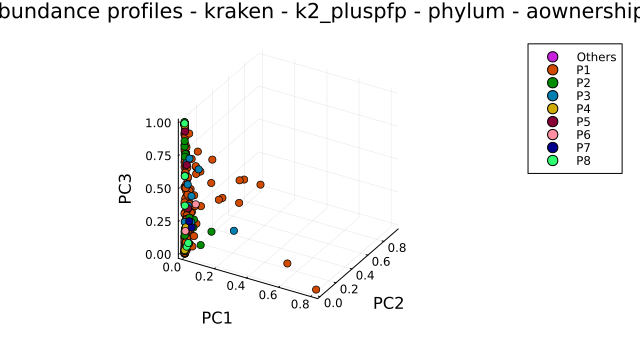

In [124]:
# for feature in feature_columns
sample2feature_table = sort(unique(rank_joint_viral_table[!, ["Run", feature]]))

unique_features = sort(unique(rank_joint_viral_table[!, feature]))
colorscheme = Colors.distinguishable_colors(length(unique_features), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)
feature2index = Dict(f => i for (i, f) in enumerate(unique_features))

xs = [Float64[] for i in 1:length(unique_features)]
ys = [Float64[] for i in 1:length(unique_features)]
zs = [Float64[] for i in 1:length(unique_features)]

for (i, row) in enumerate(DataFrames.eachrow(sample2feature_table))
    feature_index = feature2index[row[feature]]
    sample_index = sample2index[row["Run"]]
    push!(xs[feature_index], relative_abundance_matrix[1, i])
    push!(ys[feature_index], relative_abundance_matrix[2, i])
    push!(zs[feature_index], relative_abundance_matrix[3, i])
end

plot = 
StatsPlots.scatter(
    xs,
    ys,
    zs,
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    labels = hcat(unique_features...),
    title = "Viral abundance profiles - kraken - $(kraken_db) - $(taxon_level) - $(feature)",
    legend = :outertopright,
    size = (1920/3, 1080/3),
    margins = 10StatsPlots.px,
    seriescolor = hcat(colorscheme...)
)

display(plot)
    # for extension in [".png"]
    #     file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).pca") * extension
    #     StatsPlots.savefig(plot, file)
    # end
# end

In [ ]:
embedding = umap(X, n_components=3)
Q_embedding = transform(model, Q; <kwargs>)

In [ ]:
# full_table = DataFrames.innerjoin(joint_metadata, cross_sample_taxon_report_summary, on="Run" => "sample_identifier")

# full_table = DataFrames.dropmissing(full_table)


# # get virus table
# # for future levels, need to do all of these
# taxon_table = first(DataFrames.groupby(full_table, "taxon"))

# # could use MLJ for this?
# # Splitting the data
# # train_indices, test_indices = split_indices(1:DataFrames.nrow(full_table), 0.8)
# # train_data = full_table[train_indices, :]
# # test_data = full_table[test_indices, :]

# # Define the model
# # geo_loc_name
# # weekend
# # aownership
# model = GLM.lm(GLM.@formula(number_of_fragments_at_or_below_taxon ~ particle + humid + temperature + season ), taxon_table)

# # Train the model
# # GLM.fit!(model)

# # Evaluate the model
# # predictions = GLM.predict(model, taxon_table)/

In [ ]:

#     # sort taxa so largest single group is at the bottom
#     frequency_ordering = sortperm(maximum.(eachcol(counts)))
#     counts = counts[:, frequency_ordering]
#     taxon = taxon[frequency_ordering]
#     # find taxa that have no representation, and filter them out
#     is_detected = [sum(col) >= 1 for col in eachcol(counts)]
#     counts = counts[:, is_detected]
#     taxon = taxon[is_detected]

#     # # drop samples that have no data, not sure this is relevant now that we dropped negative control samples
#     # sample_has_classifications = [sum(row) > 0 for row in eachrow(counts)]
#     # counts = counts[sample_has_classifications, :]
#     # samples = samples[sample_has_classifications]
    
#     if size(counts, 2) > top_n
#         counts = counts[:, (end-top_n+1):end]
#     end
    
#     # unique_taxa = sort(unique(participant_table[!, "ncbi_taxonid"]))
#     # colorscheme = Colors.distinguishable_colors(length(unique_taxa), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

#     normalized_counts = counts ./ sum(counts, dims=2)

#     bottommargin = (maximum(length.(samples)) * 5)
#     leftmargin = 150
#     rightmargin = 25
#     topmargin = 25

#     width = max(1920, (size(counts, 1) * 12) + 300)
#     height = max(1080, bottommargin + 600)
#     height = max(height, size(counts, 2)*11)
    
#     legendfontsize=12

#     xtickdates = sort(unique(participant_table[!, ["date.end", "Run"]]))[!, "date.end"]

#     plot = StatsPlots.groupedbar(
#         log10.(counts .+ 1),
#         title = "read-classification - $(participant) - kraken - $(kraken_db) - $(taxon_level)",
#         xticks = (1:length(samples), xtickdates),
#         xlims = (0, length(samples)+1),
#         size=(width, height),
#         xrotation=90,
#         ylabel = "log10(number of reads)",
#         labels = hcat(taxon...),
#         leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
#         topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
#         rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
#         bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
#         legendmargins = 0,
#         legend = :outertopright,
#         bar_position = :stack,
#         bar_width=0.7,
#         seriescolor = hcat([taxa_to_color[t] for t in taxon]...),
#     )
#     display(plot)
#     for extension in [".png"]
#         file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-participant.$(participant).total-reads") * extension
#         StatsPlots.savefig(plot, file)
#     end

#     plot = StatsPlots.groupedbar(
#         normalized_counts,
#         title = "read-classification - $(participant) - kraken - $(kraken_db) - $(taxon_level)",
#         xticks = (1:length(samples), xtickdates),
#         xlims = (0, length(samples)+1),
#         size= (width, height),
#         xrotation=90,
#         ylabel = "proportion of reads",
#         labels = hcat(taxon...),
#         leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
#         topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
#         rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
#         bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
#         legendmargins = 0,
#         legend = :outertopright,
#         bar_position = :stack,
#         bar_width=0.7,
#         seriescolor = hcat([taxa_to_color[t] for t in taxon]...),
#     )
#     display(plot)
#     for extension in [".png"]
#         file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-participant.$(participant).normalized-reads") * extension
#         StatsPlots.savefig(plot, file)
#     end
# end